<p align="center">
  <img src="https://www.climate.gov/sites/default/files/2023-06/ENSOblog_animation_SSTA_anom_weekly_2023_Jun.gif" alt="Weekly Sea Surface Temperature Patterns from NOAA" />
</p>

# Atmospheric Data: Nino 3 SST Index

---

## Overview
Generating a wavelet power and phase spectrum from the  time-series data [Nino 3 SST Index](https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino3/)

1. Prerequisties
2. Background
3. Download and Organize Nino 3 SST Data
4. Wavelet Input Values
5. PyWavelets
6. Power Spectrum
7. Phase Spectrum

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Wavelet Basics](https://projectpythia.org/wavelet-cookbook/notebooks/wavelet-introduction/wavelet-basics.html) | Necessary | Wavelet Terminology |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Plotting on a data |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Familiarity with working with arrays |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Background

### What is an El Niño?

[Learn more!](https://oceanservice.noaa.gov/facts/ninonina.html)

### Wavelets and Atmospheric Data

TODO

## Imports

In [12]:
import pywt                      # PyWavelets
import numpy as np               # complex numbers (real and imaginary)
import xarray as xr              # working with geocat-datafiles
import geocat.datafiles as gcd   # accessing nino 3 data file
import matplotlib.pyplot as plt  # plot data

### Download and Organize Nino 3 SST Data

#### Download Nino 3 data from geocat-datafiles

In [24]:
# Download nino3 data
import geocat.datafiles as gcd

nino3_data = gcd.get('ascii_files/sst_nino3.dat')
nino3_data = np.loadtxt(nino3_data)
print(nino3_data)

[-0.15 -0.3  -0.14 -0.41 -0.46 -0.66 -0.5  -0.8  -0.95 -0.72 -0.31 -0.71
 -1.04 -0.77 -0.86 -0.84 -0.41 -0.49 -0.48 -0.72 -1.21 -0.8   0.16  0.46
  0.4   1.    2.17  2.5   2.34  0.8   0.14 -0.06 -0.34 -0.71 -0.34 -0.73
 -0.48 -0.11  0.22  0.51  0.51  0.25 -0.1  -0.33 -0.42 -0.23 -0.53 -0.44
 -0.3   0.15  0.09  0.19 -0.06  0.25  0.3   0.81  0.26  0.1   0.34  1.01
 -0.31 -0.9  -0.73 -0.92 -0.73 -0.31 -0.03  0.12  0.37  0.82  1.22  1.83
  1.6   0.34 -0.72 -0.87 -0.85 -0.4  -0.39 -0.65  0.07  0.67  0.39  0.03
 -0.17 -0.76 -0.87 -1.36 -1.1  -0.99 -0.78 -0.93 -0.87 -0.44 -0.34 -0.5
 -0.39 -0.04  0.42  0.62  0.17  0.23  1.03  1.54  1.09  0.01  0.12 -0.27
 -0.47 -0.41 -0.37 -0.36 -0.39  0.43  1.05  1.58  1.25  0.86  0.6   0.21
  0.19 -0.23 -0.29  0.18  0.12  0.71  1.42  1.59  0.93 -0.25 -0.66 -0.95
 -0.47  0.06  0.7   0.81  0.78  1.43  1.22  1.05  0.44 -0.35 -0.67 -0.84
 -0.66 -0.45 -0.12 -0.2  -0.16 -0.47 -0.52 -0.79 -0.8  -0.62 -0.86 -1.29
 -1.04 -1.05 -0.75 -0.81 -0.9  -0.25  0.62  1.22  0.

#### Plot and View Data

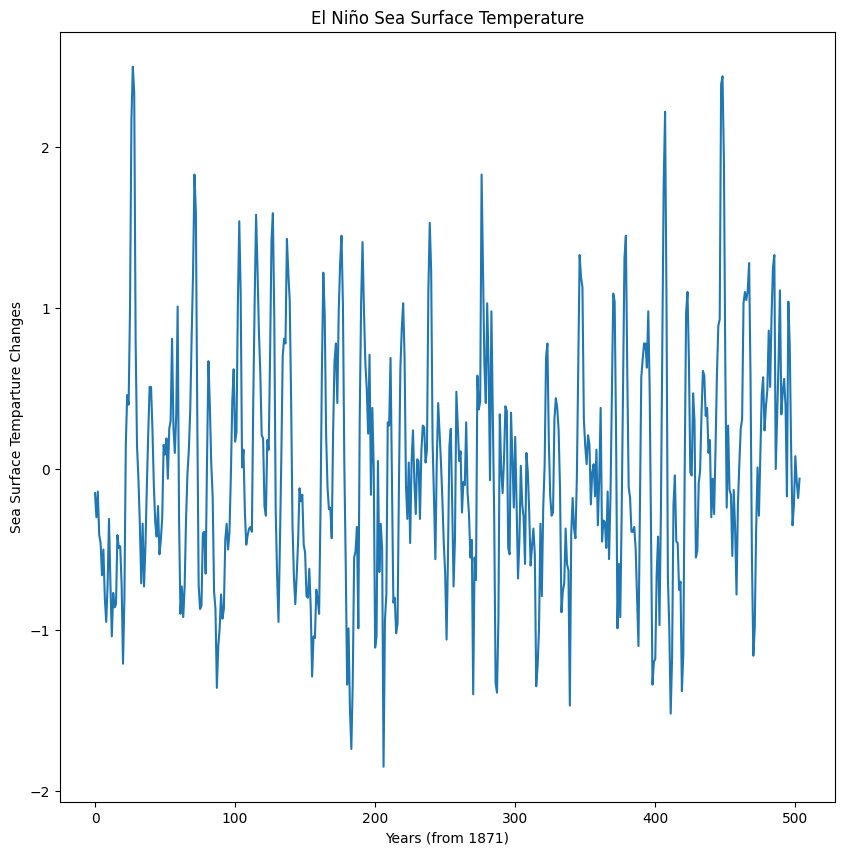

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("El Niño Sea Surface Temperature")
plt.xlabel("Years (from 1871)")
plt.ylabel("Sea Surface Temparture Changes")
plt.plot(nino3_data)
plt.show()

## Wavelet Input Values

Wavelet inputs include:

- x: Input time-series data (for example, the time and temperature data from nino3)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

In [15]:
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 44  # largest scale

### Define Complex Morlet

In [59]:
TODO: Choosing a Complex Morlet

In [16]:
bandwidth = 1.5
center_freq = 1
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.5-1


## PyWavelets

In [17]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=nino3_data, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

## Power Spectrum

In [18]:
# power spectrum (absolute value squared)
power = np.power((abs(wavelet_coeffs)), 2)

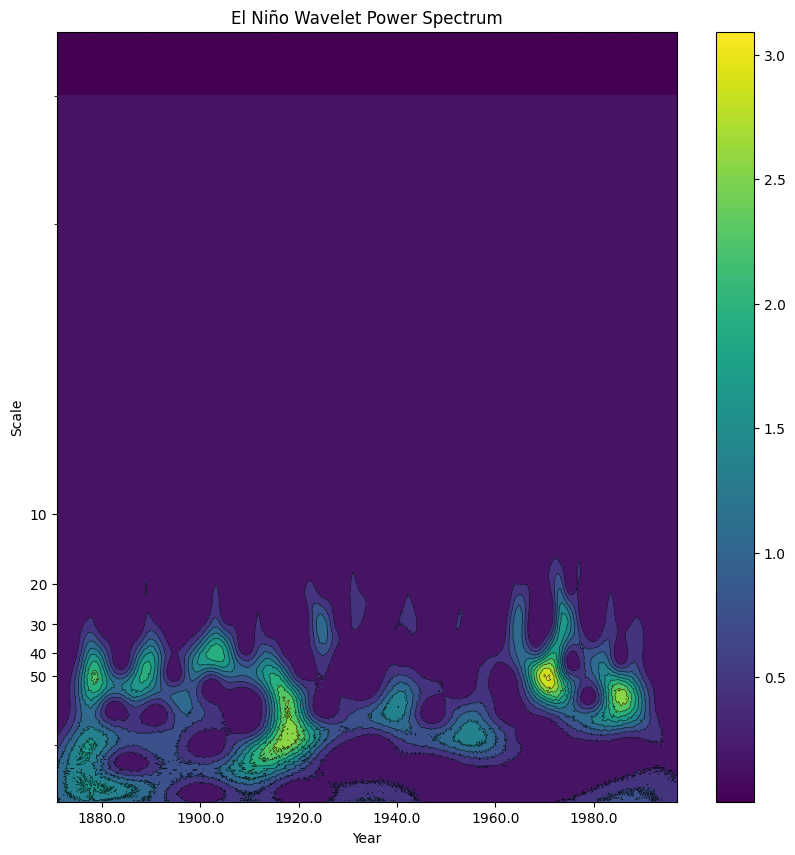

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

# Convert Y-Axis from default to symmetrical log (symlog) with labels
ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

# Plot contour around data
plt.contourf(
    power, vmax=(power).max(), vmin=(power).min(), levels=10
)
plt.contour(power, levels=10, colors="k", linewidths=0.5, alpha=0.75)

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

# Convert default X-axis from time steps of 0-504 (0-len(nino3_data)) to Years
start_year = 1871
end_year = 1871 + (len(nino3_data) * dt)
x_tickrange = np.arange(start_year, end_year, dt)
start = int(9 / dt)  # 36, starts the x-axis label at 1880 (9 years after start of data)
display_nth = int(20 / dt)  # 80, display x-axis label every 20 years
plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth])

plt.title("El Niño Wavelet Power Spectrum")
plt.xlabel("Year")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

## Phase Spectrum

In [20]:
# compare the phase spectrum
phase = np.angle(wavelet_coeffs)

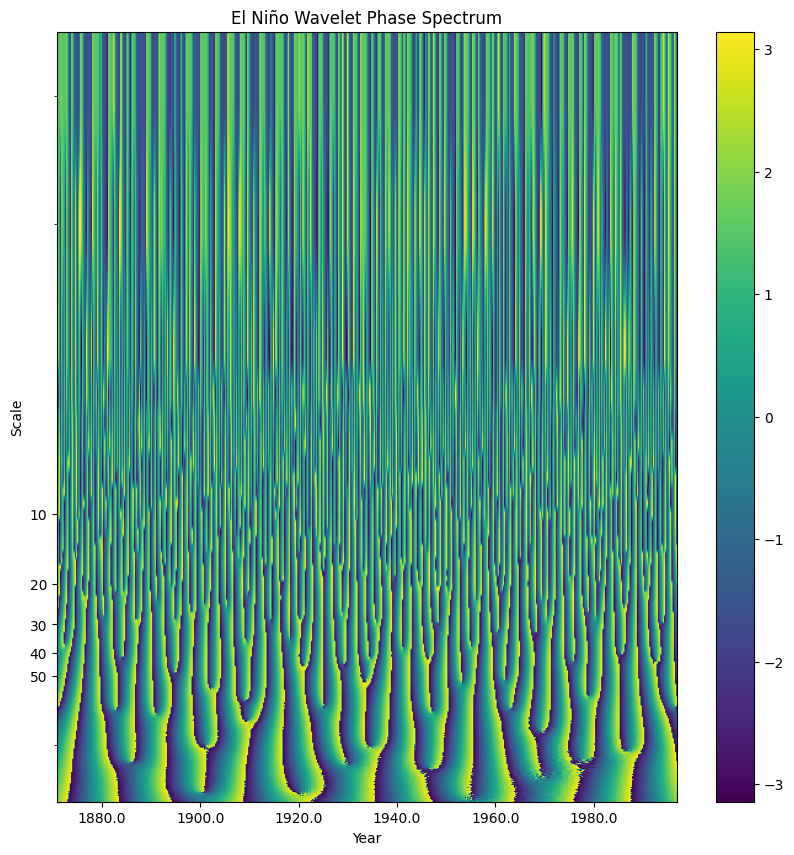

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

# Convert Y-Axis from default to symmetrical log (symlog) with labels
ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

# Plot scalogram
plt.imshow(
    phase, vmax=(phase).max(), vmin=(phase).min(), aspect="auto"
)

# Convert default X-axis from time steps of 0-504 (0-len(sst_data)) to Years
start_year = 1871
end_year = 1871 + (len(nino3_data) * dt)
x_tickrange = np.arange(start_year, end_year, dt)
start = int(9 / dt)  # 36, starts the x-axis label at 1880 (9 years after start of data)
display_nth = int(20 / dt)  # 80, display x-axis label every 20 years
plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth])

plt.title("El Niño Wavelet Phase Spectrum")
plt.xlabel("Year")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!